# A Jupyter Notebook to generate a CellML file for the selected structures in the Generic Cell Flatmap

### The description for each cell of the Jupyter Notebook is provided in order as follows:


## The required libraries

In [1]:
# Libraries

from sympy import *
from sympy.utilities.mathml import c2p

# b) Data extraction
from pyomexmeta import RDF, eUriType
import os
import sys
import xml.etree.ElementTree as ET
import rdflib
import re
from lxml import etree

# c) General
import copy
import difflib
import numpy as np
import pandas as pd
import math
import operator as op
import ast
import re
import string
import csv
import xlsxwriter

# d) Plot
import matplotlib.pyplot as plt
from matplotlib import markers
import matplotlib.font_manager as font_manager
import matplotlib.colors
from pylab import rcParams
import matplotlib.image as mpimg

### To use the code, you need to download and save the required ontologies as .csv files.

- OPB: https://bioportal.bioontology.org/ontologies/OPB

- GO: https://bioportal.bioontology.org/ontologies/GO

- FMA: https://bioportal.bioontology.org/ontologies/FMA

- CHEBI: https://bioportal.bioontology.org/ontologies/CHEBI

Since the size of the stored ontologies exceeds the GitHub upload limit, the ontologies' .csv files are not uploaded here. Change the address which points to the ontologies on your local machine.

In [2]:
# Ontologies:
# Save the .csv files of each ontology from https://bioportal.bioontology.org/ontologies
FMA = pd.read_csv('/Users/nsha457/Documents/Jupyter_files/CellmlScriptProduction/ontologies/FMA.csv')
CHEBI = pd.read_csv('/Users/nsha457/Documents/Jupyter_files/CellmlScriptProduction/ontologies/CHEBI.csv')
OPB = pd.read_csv('/Users/nsha457/Documents/Jupyter_files/CellmlScriptProduction/ontologies/OPB.csv')
GO = pd.read_csv('/Users/nsha457/Documents/Jupyter_files/CellmlScriptProduction/ontologies/GO.csv')

# Extraction of IDs & Labels in the ontologies
fmaID = FMA['Class ID']
fmaLabel= FMA['Preferred Label']
chebiID = CHEBI['Class ID']
chebiLabel= CHEBI['Preferred Label']
opbID = OPB['Class ID']
opbLabel= OPB['Preferred Label']
goID = GO['Class ID']
goLabel= GO['Preferred Label']

c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3325: DtypeWarning: Columns (41,71,75,77,99,100,103,113,114,138,140,156,157,158,178,198) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3325: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\users\nsha457\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3325: DtypeWarning: Columns (11,12,43) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Defining thetemplate groups
Here, a dictionary (**templateGroups**) has been generated to define which group of transporters/structures belong to which template. Template names are the keys **SLC1, SLC2, ..., SLC14** and the dictionary values represent the name of the structures belonging each template. For each transporters/structure we need to have a CellML file in which their specific parameters are initialized and annotated. These files don't need to include any mathematical equations.
In this example, we have considered two templates: **SLC2 & SLC4**

In [3]:
# Here we see which group of transporters/channels belong to which template
templateGroups = {'SLC2':['SLC2A1','SLC2A2','SLC2A3'],
                  'SLC4':['SLC4A1','SLC4A2','SLC4A3']}

## Finding the appropriate templates
Here, we assume that the structures **SLC2A1 & SLC4A1** are selected from the flatmap. The goal is to generate a bond graph model of the composed structure (**SLC2A1+SLC4A1**) and provide a **CellML** file along with a **JSON** file. In this cell we find the required templates to use for the structure names. The dictionary **'inUse'** maps between the selected structures and their templates.

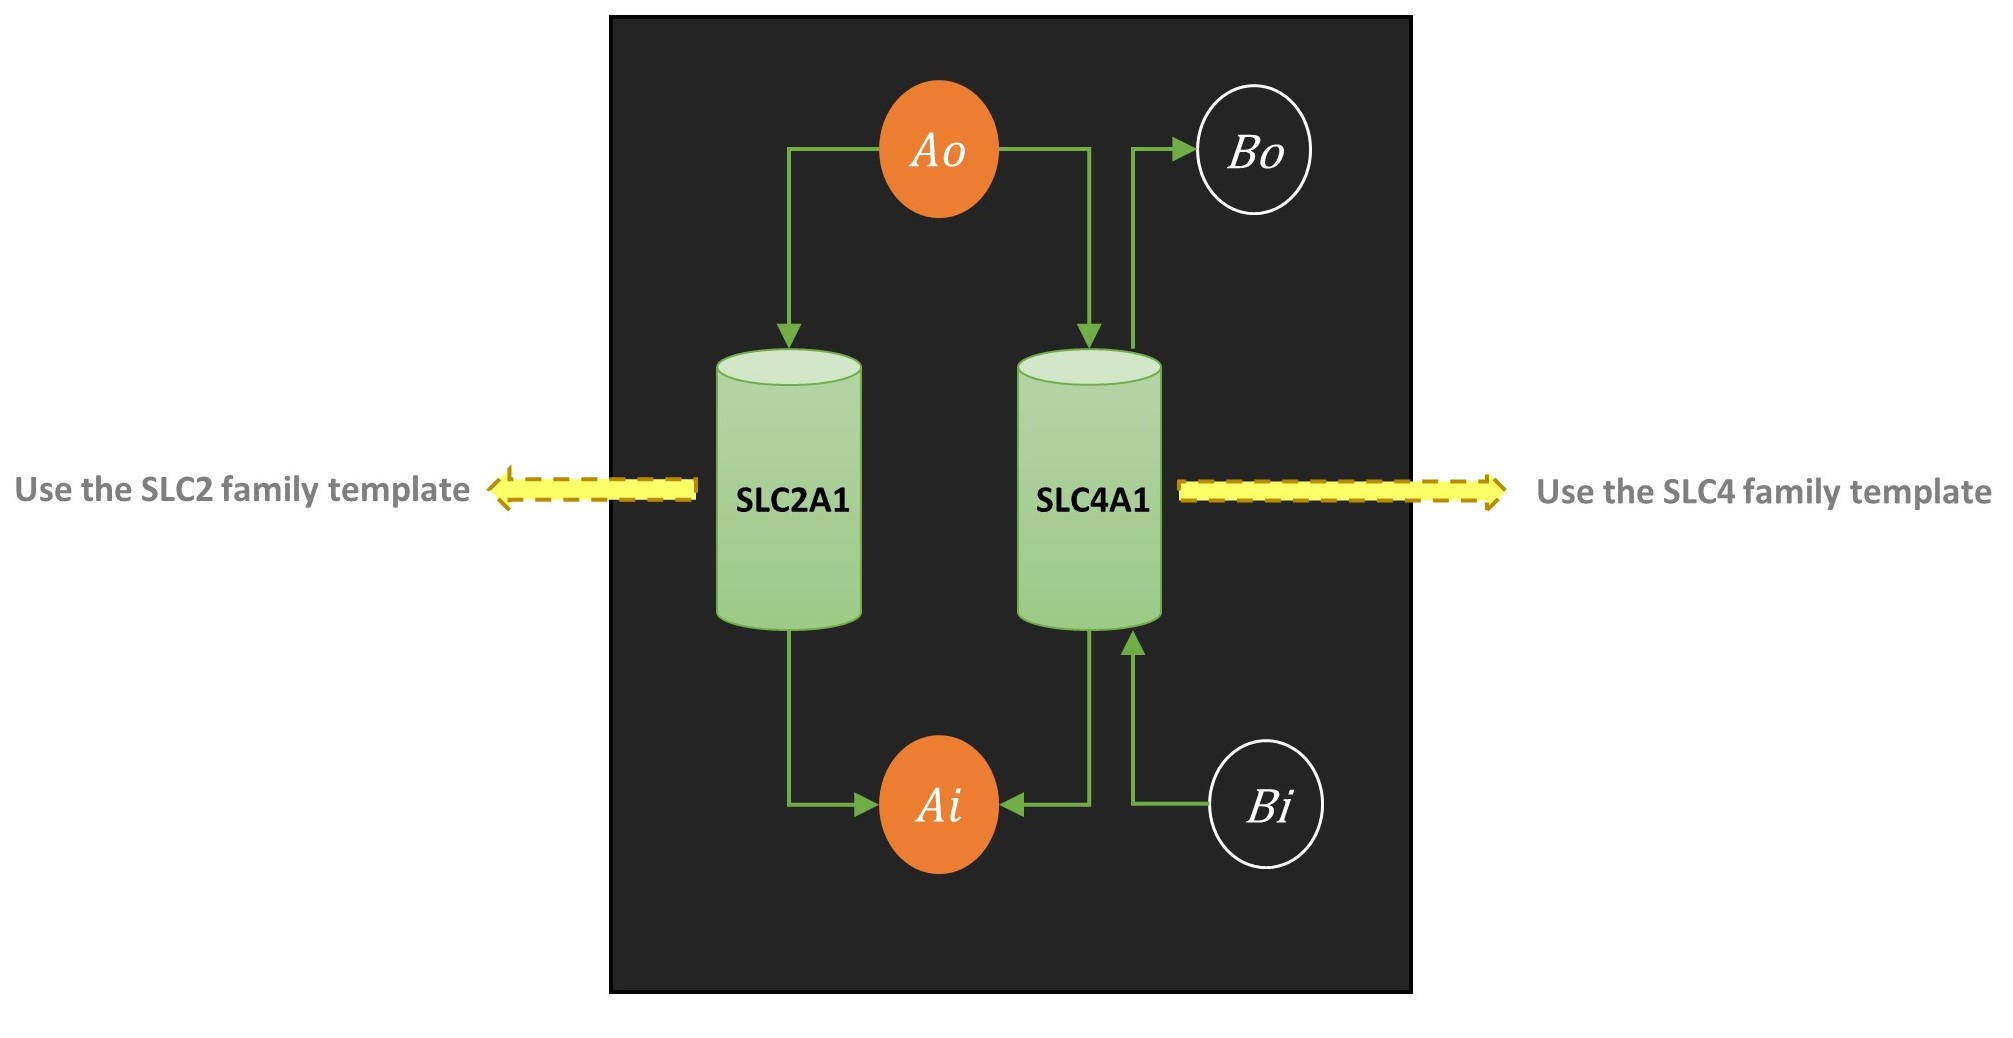

In [8]:
channelSelected = ['SLC4A1', 'SLC2A1']
inUse={}
for selected in channelSelected:
    for key in templateGroups.keys():
        for transporterName,i in zip(templateGroups[key],range(len(templateGroups[key]))):
            if selected == transporterName:
                inUse[selected]=[]
                inUse[transporterName].append(key)
            

print('inUse ==>' ,inUse)  

inUse ==> {'SLC4A1': ['SLC4'], 'SLC2A1': ['SLC2']}


## Retrieve the annotations

Retreiving the annotations from the CellML parameter files. 
The biological structures might have the same bond grpah representation (template) but each structure has its own unique parameter values.
We have stored the parameters for each structure in a CellML file. The parameters are annotated and the file name has the same name as the biological structure. For example, here the structures **SLC2A1 & SLC4A1** are selected from the flatmap and the parameters are retrieved from **SLC2A1.cellml & SLC4A1.cellml**. Using the following function (**getAnnotations**), we extract the annotations as RDFs.

In [9]:
# Retreiving the annotations from the CellML parameter files
def getAnnotations(add):
    parser = etree.XMLParser(recover=True)
    root = etree.parse(add, parser).getroot()
    rdfGraph = rdflib.Graph()
    for rdfElement in root.iter():
        if rdfElement.tag.endswith('RDF'):
            try:
                rdfGraph.parse(data = etree.tostring(rdfElement), format="application/rdf+xml")
            except:
                pass
            
    def getLeaves(sbj, graph):
        triples = list(graph.triples((sbj,None,None)))
        leaves = []
        if len(triples)>0:
            for s, p, o in triples:
                result =  getLeaves(o,graph)
                leaves += result
            return list(set(leaves))
        else:
            return [sbj]
        
    # Opens the CellML file and returns the list of variables names
    f = open(add,'r')
    text = f.read()
    root = ET.fromstring(text)

    rdfs = root.findall('{http://www.w3.org/1999/02/22-rdf-syntax-ns#}RDF')

    List1=[]
    for child in rdfs:
        for grand in child:
            List1.append(grand.attrib.get('{http://www.w3.org/1999/02/22-rdf-syntax-ns#}about'))
    
    List = list(dict.fromkeys(List1))
    if '#metaid0' in List:
        List.remove('#metaid0')
        
        
    triplesList={}
    for i in range(len(List)):
        sbj = rdflib.URIRef(List[i])
        triplesList[i]=getLeaves(sbj, rdfGraph)


    rdfs=[]
    
    for item in triplesList:
        d = []
        for k in range(len(triplesList[item])):
            if 'opb' in triplesList[item][k] or 'chebi' in triplesList[item][k] or 'fma' in triplesList[item][k] or 'go' in triplesList[item][k]: 
                lSplit= triplesList[item][k].split('/')
                d.append(lSplit[-1])
            else: # free-style descriptions!
                d.append(str(triplesList[item][k]))
    
        rdfs.append(d)

    for child in root:
        if child.tag == '{http://www.cellml.org/cellml/1.1#}'+'component':
            modelComponentName = child.attrib.get('name')
    
    
    listP = []
    for item in List:
        for x in item.split('.'):
            if '#'+modelComponentName == x:
                itemP = item.replace(x+'.', '')
                listP.append(itemP)
                

            
    return [listP,rdfs,root]

## Retrieve the values

The function **valExtraction** retreives the initial values from the CellML parameter files (here, **SLC2A1.cellml & SLC4A1.cellml**). 

In [10]:
def valExtraction(root,List): 
    
    init=[]; variables=[]; els=[]
    
    for child in root:
        if child.tag == '{http://www.cellml.org/cellml/1.1#}'+'component':
            modelComponentName = child.attrib.get('name')
            
    components = root.findall('{http://www.cellml.org/cellml/1.1#}component')
    
    for comp in components:
        variables.append(comp.findall('{http://www.cellml.org/cellml/1.1#}variable'))
        
    for element in List:  
        for var in variables:
            for v in var:   
                if modelComponentName+'.'+element == v.attrib['{http://www.cellml.org/metadata/1.0#}id']:
                    if 'initial_value' in v.attrib: # if any initial value exists take it
                        init.append(v.attrib['initial_value'])    
                    else:
                        init.append(None)
    return init

## An all-in-one dictionary

For the ease of access, a dictionary (**parametersData**) is defined in which the keys represent the structures' names and the values represent the variable name, RDF, and initial value for each parameter. The structure of the dictionary is as follows:

```parametersData[SLC1] = [[variable1 , RDF1 , initial value1], [variable2 , RDF2 , initial value2],...]```

In [11]:
annotations={}
for transporterName in inUse:
    addressP = '/Users/nsha457/Documents/Jupyter_files/CellmlScriptProduction/enzymes/{0}.cellml'.format(transporterName)
    [List,rdfs,root] = getAnnotations(addressP)
    initialVals = valExtraction(root,List)
    annotations[transporterName] = []
    annotations[transporterName] = [List,rdfs,initialVals]
    
parametersData = {}
for key in annotations:
    parametersData[key] = []
    for j in range(len(annotations[key][0])):
        parametersData[key].append([annotations[key][0][j],annotations[key][1][j],annotations[key][2][j]])
            
            

## Checking for linking points

To find out how the selected biological structures must be connected to each other, we need to find their mutual entities/components. For instance, in the surrent example of **SLC2A1 & SLC4A1**, the concentrations of **Ai** and **Ao** are common between the two structures. This is understood by the following function (**checkMutual**). This function searches for identical RDFs among the selected models in the **parametersData** dictionary. If the common entities do not have the same initial values, the function asks the user to choose between the values or insert a new value. The dictionary **parametersData** will then be updated by the new inserted values.

You'll see that the initial concentration of  ```['FMA:226050', 'OPB_00340', 'CHEBI:39123']```) and ```['FMA:226050', 'OPB_00079', 'CHEBI:39123']``` have different values in SLC2A1 & SLC4A1. In both cases we decided to insert new values.

In [12]:
def checkMutual(parametersData):

    repeat = []
    mutualVars={}
    commonAnnotsDiffVals = {}; CommonAmountsAA = {}; CommonAmountsBB = {};
    for k1 in range(len(list(parametersData))):
        for k2 in range(len(list(parametersData))):
            if list(parametersData)[k1] != list(parametersData)[k2] and (list(parametersData)[k1],list(parametersData)[k2]) not in repeat and (list(parametersData)[k2],list(parametersData)[k1]) not in repeat:    
                if (list(parametersData.keys())[k1],list(parametersData.keys())[k2]) not in mutualVars:
                    mutualVars[(list(parametersData.keys())[k1],list(parametersData.keys())[k2])]=[]

                for i1 in range(len(list(parametersData.values())[k1])):
                    for i2 in range(len(list(parametersData.values())[k2])):
                        if all(elem in list(parametersData.values())[k1][i1][1] for elem in list(parametersData.values())[k2][i2][1]):
                            repeat.append((list(parametersData)[k1],list(parametersData)[k2]))

                            mutualVars[(list(parametersData.keys())[k1],list(parametersData.keys())[k2])].append(list(parametersData.values())[k1][i1][0])
                            mutualVars[(list(parametersData.keys())[k1],list(parametersData.keys())[k2])].append(list(parametersData.values())[k1][i1][1])

                            if list(parametersData.values())[k1][i1][2] != list(parametersData.values())[k2][i2][2]:

                                if (list(parametersData.keys())[k1],list(parametersData.keys())[k2]) not in commonAnnotsDiffVals:
                                    commonAnnotsDiffVals[(list(parametersData.keys())[k1],list(parametersData.keys())[k2])]=[]
                                    CommonAmountsAA[(list(parametersData.keys())[k1],list(parametersData.keys())[k2])] = []
                                    CommonAmountsBB[(list(parametersData.keys())[k1],list(parametersData.keys())[k2])] = []

                                commonAnnotsDiffVals[(list(parametersData.keys())[k1],list(parametersData.keys())[k2])].append(list(parametersData.values())[k1][i1][1])
                                CommonAmountsAA[(list(parametersData.keys())[k1],list(parametersData.keys())[k2])].append(list(parametersData.values())[k1][i1][2])
                                CommonAmountsBB[(list(parametersData.keys())[k1],list(parametersData.keys())[k2])].append(list(parametersData.values())[k2][i2][2])

    # Getting the preferred value from the user for the recognised same variables with different values
    for i in range(len(list(commonAnnotsDiffVals.keys()))):
        for j in range(len(list(commonAnnotsDiffVals.values())[i])):
            print('Different values found for: ')
            print('\n')
            print(list(commonAnnotsDiffVals.values())[i][j] ,list(commonAnnotsDiffVals.keys())[i],':',list(CommonAmountsAA.values())[i][j],  'and' , list(CommonAmountsBB.values())[i][j])   
            list(CommonAmountsAA.values())[i][j]=copy.deepcopy(input('Enter the preferred value:'))


    # Copying the changed values to the list of initial amounts of the model    
    for mutualTransporters in commonAnnotsDiffVals: # (x,y)
        for val1,i in zip(commonAnnotsDiffVals[mutualTransporters],range(len(commonAnnotsDiffVals[mutualTransporters]))):
            for transporterName in parametersData: 
                for val2 in parametersData[transporterName]:
                    if transporterName == mutualTransporters[0] and all(elem in val1 for elem in val2[1]):
                        val2[2] = copy.deepcopy(CommonAmountsAA[mutualTransporters][i])
                    if transporterName == mutualTransporters[1] and all(elem in val1 for elem in val2[1]):
                        val2[2] = copy.deepcopy(CommonAmountsAA[mutualTransporters][i])

    return [parametersData,mutualVars]               

In [13]:
[parametersData,mutualVars] = checkMutual(parametersData)

Different values found for: 


['CHEBI:39123', 'OPB_00340', 'FMA:226050'] ('SLC4A1', 'SLC2A1') : 1 and 10
Enter the preferred value:5
Different values found for: 


['CHEBI:39123', 'OPB_00079', 'FMA:226050'] ('SLC4A1', 'SLC2A1') : 10 and 1
Enter the preferred value:2


## Reference annotations

As mentioned before, multiple biological structures can be modelled using one single template. Initially, the templates have components with random names. We need to have a reference to see which annotations (RDFs) can be assigned to these components. For example, in the 'SLC2' template, the component ```Ai``` can be either ```['FMA:226050', 'OPB_00340', 'CHEBI:39123']``` or ```["randomRDF1"]```. This reference is defined in **referenceAnnotations**.

In [14]:
referenceAnnotations = {'SLC2': [{'Ai':[['FMA:226050', 'OPB_00340', 'CHEBI:39123'],["randomRDF1"]]},
                                {'Ao':[['OPB_00340', 'FMA:70022', 'CHEBI:39123'], ["randomRDF2"]]},
                                {'Ei':[['FMA:226050', 'OPB_00340', 'CHEBI:38807'], ["randomRDF3"]]},
                                {'Eo':[['OPB_00340', 'FMA:70022', 'CHEBI:38807'], ["randomRDF4"]]},
                                {'EAi':[['CHEBI:81851', 'FMA:226050', 'OPB_00340'], ["randomRDF5"]]},                              
                                {'EAo':[['CHEBI:81851', 'OPB_00340', 'FMA:70022'], ["randomRDF6"]]},
                                {'K_Ai':[['OPB_00079', 'FMA:226050', 'CHEBI:39123'], ["randomRDF7"]]},
                                {'K_Ao':[['OPB_00079', 'FMA:70022', 'CHEBI:39123'], ["randomRDF8"]]},
                                {'K_Ei':[['OPB_00079', 'FMA:226050', 'CHEBI:38807'], ["randomRDF9"]]},
                                {'K_Eo':[['OPB_00079', 'FMA:70022', 'CHEBI:38807'], ["randomRDF10"]]},
                                {'K_EAi':[['CHEBI:81851', 'FMA:226050', 'OPB_00079'], ["randomRDF11"]]},
                                {'K_EAo':[['CHEBI:81851', 'FMA:70022', 'OPB_00079'], ["randomRDF12"]]},
                                {'kappa_Re1':[['CHEBI:64297', 'SLC2A1_Re1', 'OPB_01296'], ["randomRDF13"]]},
                                {'kappa_Re2':[['SLC2A1_Re2', 'CHEBI:64297', 'OPB_01296'], ["randomRDF14"]]},
                                {'kappa_Re3':[['CHEBI:64297', 'SLC2A1_Re3', 'OPB_01296'], ["randomRDF15"]]},
                                {'kappa_Re4':[['SLC2A1_Re4', 'CHEBI:64297', 'OPB_01296'], ["randomRDF16"]]},],
                       'SLC4': [{'Ai':[['FMA:226050', 'OPB_00340', 'CHEBI:39123'],["randomRDF17"]]},
                                {'Ao':[['OPB_00340', 'FMA:70022', 'CHEBI:39123'], ["randomRDF18"]]},
                                {'Ei':[['CHEBI:39000', 'OPB_00340', 'FMA:226050'], ["randomRDF19"]]},
                                {'Eo':[['CHEBI:39000', 'OPB_00340', 'FMA:70022'], ["randomRDF20"]]},
                                {'EAi':[['CHEBI:31340', 'FMA:226050', 'OPB_00340'], ["randomRDF21"]]},
                                {'EAo':[['CHEBI:31340', 'FMA:70022', 'OPB_00340'], ["randomRDF22"]]},
                                {'Bi':[['OPB_00340', 'FMA:226050', 'CHEBI:29101'], ["randomRDF23"]]},
                                {'Bo':[['OPB_00340', 'FMA:70022', 'CHEBI:29101'], ["randomRDF24"]]},
                                {'EBi':[['OPB_00340', 'FMA:226050', 'CHEBI:62965'], ["randomRDF25"]]},
                                {'EBo':[['OPB_00340', 'FMA:70022', 'CHEBI:62965'], ["randomRDF26"]]},
                                {'K_Ai':[['FMA:226050', 'CHEBI:39123', 'OPB_00079'],["randomRDF27"]]},
                                {'K_Ao':[['OPB_00079', 'FMA:70022', 'CHEBI:39123'], ["randomRDF28"]]},
                                {'K_Ei':[['CHEBI:39000', 'OPB_00079', 'FMA:226050'], ["randomRDF29"]]},
                                {'K_Eo':[['CHEBI:39000', 'OPB_00079', 'FMA:70022'], ["randomRDF30"]]},
                                {'K_EAi':[['CHEBI:31340', 'OPB_00079', 'FMA:226050'], ["randomRDF31"]]},
                                {'K_EAo':[['CHEBI:31340', 'OPB_00079', 'FMA:70022'], ["randomRDF32"]]},
                                {'K_Bi':[['OPB_00079', 'FMA:226050', 'CHEBI:29101'], ["randomRDF33"]]},
                                {'K_Bo':[['OPB_00079', 'FMA:70022', 'CHEBI:29101'], ["randomRDF34"]]},
                                {'K_EBi':[['OPB_00079', 'FMA:226050', 'CHEBI:62965'], ["randomRDF35"]]},
                                {'K_EBo':[['OPB_00079', 'FMA:70022', 'CHEBI:62965'], ["randomRDF36"]]},
                                {'kappa_Re1':[['CHEBI:64297', 'SLC4A1_Re1', 'OPB_01296'], ["randomRDF37"]]},
                                {'kappa_Re2':[['CHEBI:64297', 'SLC4A1_Re2', 'OPB_01296'], ["randomRDF38"]]},
                                {'kappa_Re3':[['CHEBI:64297', 'SLC4A1_Re3', 'OPB_01296'], ["randomRDF39"]]},
                                {'kappa_Re4':[['CHEBI:64297', 'SLC4A1_Re4', 'OPB_01296'], ["randomRDF40"]]},
                                {'kappa_Re5':[['CHEBI:64297', 'SLC4A1_Re5', 'OPB_01296'], ["randomRDF41"]]},
                                {'kappa_Re6':[['CHEBI:64297', 'SLC4A1_Re6', 'OPB_01296'], ["randomRDF42"]]},
                               ]}

## Defining the templates using dictionaries

3 primary dictionaries work as templates for bond graph models of biological structures:

- **Reactions:** for each template (SLC2, SLC4, ...) the reactions are defined.

- **reaction_reactants_templates:** the reactants along with their stoichiometries are defined for each reaction inside the templates.

- **reaction_products_templates:** the products along with their stoichiometries are defined for each reaction inside the templates.

It's worth mentioning that the concentrations' names used in the templates (the above 3 dictionaries) are the same arbitrary names used in **referenceAnnotations**. The specified models will be created in the next stage by applying the extracted annotations from the selected CellML files.

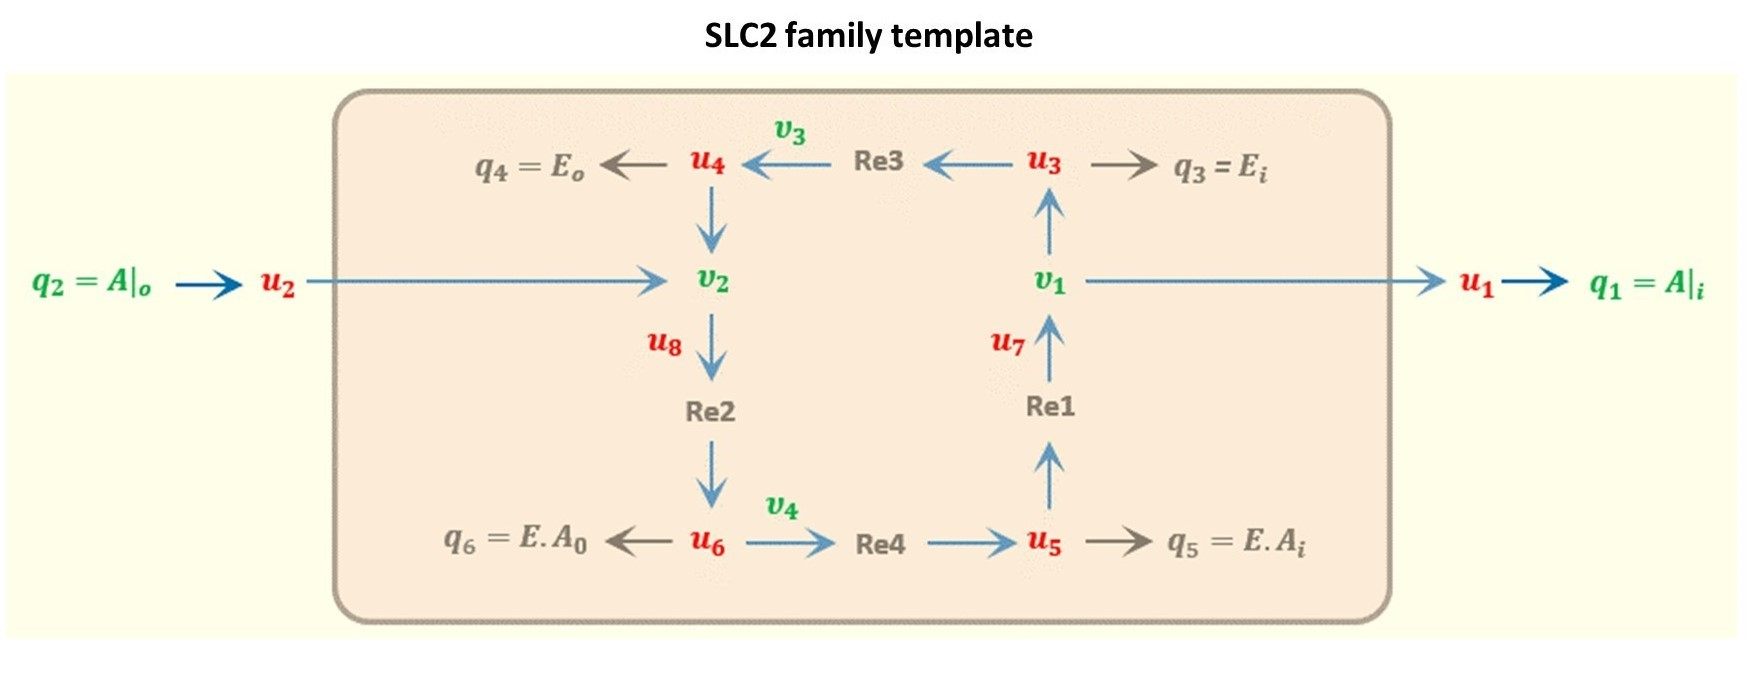

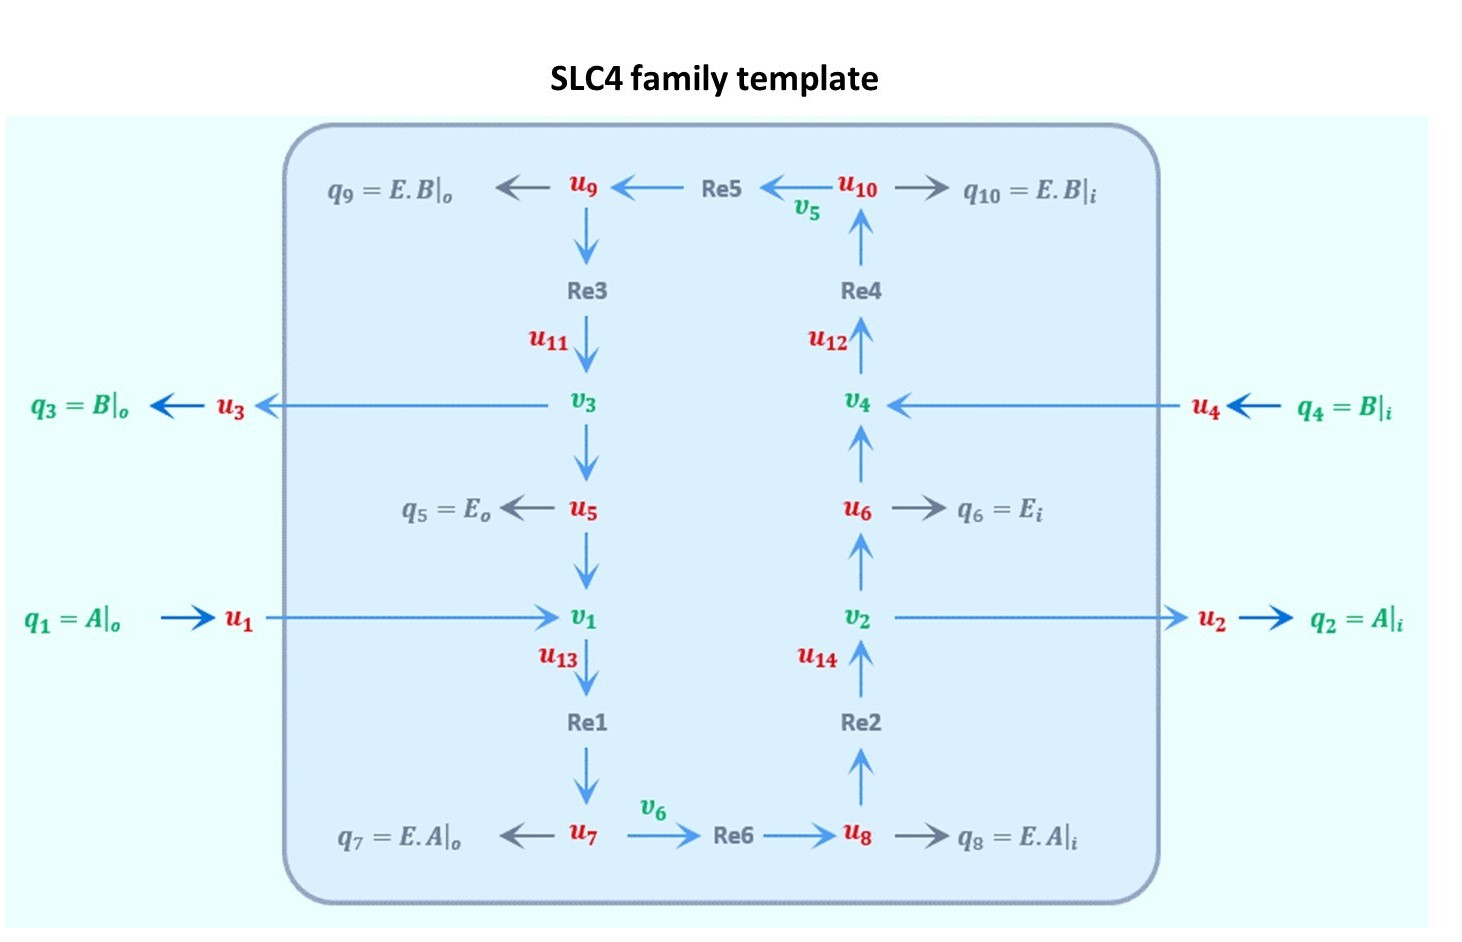

In [15]:
Reactions={'SLC2': ['Re1', 'Re2', 'Re3', 'Re4'],
           'SLC4': ['Re1', 'Re2', 'Re3', 'Re4', 'Re5', 'Re6']}

reaction_reactants_templates={'SLC2': [{'Re1':[(1,'EAi')]}, {'Re2':[(1,'Eo'),(1,'Ao')]}, {'Re3':[(1,'Ei')]}, {'Re4':[(1,'EAo')]}],
                              'SLC4': [{'Re1':[(1,'Ao'),(1,'Eo')]}, {'Re2':[(1,'EAi')]}, {'Re3':[(1,'EBo')]}, {'Re4':[(1,'Bi'),(1,'Ei')]}, {'Re5':[(1,'EBi')]}, {'Re6':[(1,'EAo')]}]   }

reaction_products_templates={'SLC2': [{'Re1':[(1,'Ai'),(1,'Ei')]}, {'Re2':[(1,'EAo')]}, {'Re3':[(1,'Eo')]}, {'Re4':[(1,'EAi')]}],
                             'SLC4': [{'Re1':[(1,'EAo')]}, {'Re2':[(1,'Ai'),(1,'Ei')]}, {'Re3':[(1,'Bo'),(1,'Eo')]}, {'Re4':[(1,'EBi')]}, {'Re5':[(1,'EBo')]}, {'Re6':[(1,'EAi')]}]}


## Structure specific model creation

Combining the data from **parametersData** and the templates' information (**reaction_reactants_templates** & **reaction_products_templates**). This adds the RDFs to the templates. Two dictionaries are generated:

- reaction_reactants

- reaction_products

Each of these two dictionaries include the initial values and the RDF for the reactants/products for each reaction inside the biological structures. For instance, **reaction_reactants** reads:

```{'SLC4A1_Re2': [(1, ['CHEBI:31340', 'FMA:226050', 'OPB_00340', 'SLC4A1'])],```
```'SLC4A1_Re6': [(1, ['CHEBI:31340', 'FMA:70022', 'OPB_00340', 'SLC4A1'])], ...}```

This means that the reaction ```Re2``` in the structure ```SLC4A1``` has a reactant with the stoichiometry of ```1``` and RDF of ```['CHEBI:31340', 'FMA:226050', 'OPB_00340', 'SLC4A1']```.

In [16]:
reaction_reactants={}
reaction_products={}
for transporterName in parametersData:  
    for entity in parametersData[transporterName]:
        for reaction in Reactions[inUse[transporterName][0]]:
            if transporterName+'_'+reaction in entity[1]:
                reaction_reactants[transporterName+'_'+reaction]=[]
                reaction_products[transporterName+'_'+reaction]=[]
                for stoi in reaction_reactants_templates[inUse[transporterName][0]]:
                    for key,values in stoi.items():
                        if key == reaction:
                            for value in values: # (value[0],value[1])=(1,Ai)
                                for reference in referenceAnnotations[inUse[transporterName][0]]:
                                    for ID in reference:
                                        for annot in reference[ID]:
                                            if ID == value[1]: 
                                                for entity0 in parametersData[transporterName]:
                                                    if all(element in annot for element in entity0[1]):
                                                        X=copy.deepcopy(annot)
                                                        X.append(transporterName)
                                                        reaction_reactants[transporterName+'_'+reaction].append((value[0],X))
                for stoi in reaction_products_templates[inUse[transporterName][0]]:
                    for key,values in stoi.items():
                        if key == reaction:
                            for value in values: # (value[0],value[1])=(1,Ai)
                                for reference in referenceAnnotations[inUse[transporterName][0]]:
                                    for ID in reference:
                                        for annot in reference[ID]:
                                            if ID == value[1]: 
                                                for entity0 in parametersData[transporterName]:
                                                    if all(element in annot for element in entity0[1]):
                                                        X=copy.deepcopy(annot)
                                                        X.append(transporterName)
                                                        reaction_products[transporterName+'_'+reaction].append((value[0],X))                                           

## List of fluxes and list of species

In the next cell all the fluxes and species are categorized for later application. Here, ```V``` is a list of all the fluxes (related to the reactions) and ```Species``` is a list of all the species found in the models. Next, since there might be duplicate species in the ```Species``` list, a list of non-repetitive species is created (```speciesNoDuplicate```). As well as the non-repetitive species, we generate a list of their corresponding species constants in ```speciesConstants```.

In [17]:
V = []
for flux in reaction_reactants:
    V.append(flux)
    
Species = []
for transporterName in parametersData:
    for entity in parametersData[transporterName]:
        if 'OPB_00340' in entity[1]:
            X = copy.deepcopy(entity[1])
            X.append(transporterName)
            Species.append(X)
            
speciesNoDuplicate = []
for s in Species:
    for transporterName in inUse:
        if transporterName in s:
            ss = copy.deepcopy(s)
            ss.remove(transporterName)
            if ss not in speciesNoDuplicate:
                speciesNoDuplicate.append(ss)
                
speciesConstants=[]
for species in speciesNoDuplicate:
    X = copy.deepcopy(species)
    X.remove('OPB_00340')
    for transporterName in parametersData:
        for entity in parametersData[transporterName]:
            if all(el in entity[1] for el in ['OPB_00079']+X) and entity[1] not in speciesConstants:
                speciesConstants.append(entity[1])

In [18]:
# might just be needed for parameter estimation

# speciesAndRatesList = Species + V


# reactionEquations = np.zeros((len(V),len(speciesAndRatesList))) 

    
# for r,reaction in zip(range(len(V)),V):
#     for s in range(len(speciesAndRatesList)):
#         if speciesAndRatesList[s] == V[r]:
#             reactionEquations[r][s] = 1
            
# # substrates & products (MA)
# for reaction in reaction_reactants:  
#     for r,rate in zip(range(len(V)),V):
#         if reaction in rate:
#             for stoi,ids in reaction_reactants[reaction]:
#                 for s in range(len(speciesAndRatesList)):
#                     if all(el in speciesAndRatesList[s] for el in ids):
#                         reactionEquations[r][s] = -stoi
#             for stoi,ids in reaction_products[reaction]:
#                 for s in range(len(speciesAndRatesList)):
#                     if all(el in speciesAndRatesList[s] for el in ids):
#                         reactionEquations[r][s] = stoi


## Generating the "N" matrix

In this cell, the conservation law for the **0-nodes** is determined. The concentration of the species is formulated as ODEs. Matrix **N** demonstrates how the ODEs are related to the fluxes. The rows of the matrix represent the number of species in all the models (no duplicates) and the columns represent all the fluxes for reactions. The elements of **N** are:

- ***'0':*** in this case, the corresponding flux has no effect on the concentration of the species.

- ***positive:*** The species is being produced by that specific reaction.

- ***negative:*** The species is being consumed in that specific reaction.

In [19]:
M=np.zeros((len(Species),len(V)))
for s in range(len(Species)):
    for key,i in zip(reaction_products,range(len(reaction_products))):
        for stoi,val  in reaction_products[key]:
            if all(el in val for el in Species[s]):
                M[s][i] = stoi
    for key,i in zip(reaction_reactants,range(len(reaction_reactants))):
        for stoi,val in reaction_reactants[key]:
            if all(el in val for el in Species[s]):
                M[s][i] = -stoi
    

N=np.zeros((len(speciesNoDuplicate),len(V)))
for transporterName in inUse:
    for v,i in zip(V,range(len(V))):
        if transporterName in v:
            for s1 in range(len(speciesNoDuplicate)):
                for s2 in range(len(Species)):
                    if transporterName in Species[s2]:
                        if all(el in Species[s2] for el in speciesNoDuplicate[s1]):
                            N[s1][i] = M[s2][i]

# Writing the CellML code in a text file

Here, a CellML file is created and the units are imported from the units file: **units_BG.cellml**. One can change the units for different entities from **units_BG.cellml** as long as the units' names are not changed. For example the unit of biochemical concentrations is **concentrationUnit** in the main CellML file and **units_BG.cellml**. This name must remain untouched but its definition can be changed in **units_BG.cellml**.

The variables include all the entities taken from the lists: 

- speciesNoDuplicate: for biochemical concentrations. In the CellML file they're named as ```q_0, q_1,...```

- speciesConstants: for the species constants. In the CellML file they're named as ```K_0, K_1,...```

- V: for reaction fluxes and reaction rate constants. In the CellML file reaction fluxes are named as ```v_0, v_1,...``` and the reaction rate constants are named as ```kappa_0, kappa_1,...```


The information required for the 0-nodes are taken from the ```N``` matrix and the required for the 1-nodes are taken from the templates ```reaction_reactants``` and ```reaction_products```.


Along with generating the CellML variables, a list will also be created in which each variable is mapped to its annotation (RDF). This will be used later in outputing a JSON file as a complimentary information to the CellML file.

In [20]:
# Create a text file (TEXT)

unitsImport = ['def model composed_model as',
               '\tdef import using "units_BG.cellml" for',
                '\t\tunit concentrationUnit using unit concentrationUnit;',
               '\t\tunit speciesConstantUnit using unit speciesConstantUnit;',
               '\t\tunit fluxUnit using unit fluxUnit;',
                '\tenddef;',
              '\tdef comp main as']

with open('GFG.txt', 'w') as fp:
    pass    
with open('GFG.txt', 'a') as file:
    for line in unitsImport:
        file.write(line+'\n')

        
with open('GFG.txt', 'a') as file:
    file.write('\t\tvar t: second {init: 0};'+'\n')
    
cellmlRef=[]        

q = ['q_{0}'.format(x) for x in range(1000)]
k=0
checkDup=[]
for species,i in zip(speciesNoDuplicate,range(len(speciesNoDuplicate))):
        for transporterName,annotation in parametersData.items():
            for value in annotation:
                if all(el in value[1] for el in species):
                    flag=0; 
                    for j in range(len(checkDup)):
                        if all(x in checkDup[j] for x in value[1]):
                            flag=1
                                
                    if flag==0:
                        checkDup.append(value[1])
                        cellmlRef.append((value[1],q[k],'concentrationUnit'))
                        with open('GFG.txt', 'a') as file:
                            file.write('\t\tvar ' +q[k]+': '+'concentrationUnit '+'{'+'init: '+value[2]+'}'+';'+'\n')
                            k+=1
                        
K = ['K_{0}'.format(x) for x in range(1000)]
k=0
checkDup=[]
for constant,i in zip(speciesConstants,range(len(speciesConstants))):
    for transporterName,annotation in parametersData.items():
        for value in annotation:
            if all(el in value[1] for el in constant):
                flag=0; 
                for j in range(len(checkDup)):
                    if all(x in checkDup[j] for x in value[1]):
                        flag=1

                if flag==0:
                    checkDup.append(value[1])
                    cellmlRef.append((value[1],K[k],'speciesConstantUnit'))
                    with open('GFG.txt', 'a') as file:
                        file.write('\t\tvar '+K[k]+': '+'speciesConstantUnit '+'{'+'init: '+value[2]+'}'+';'+'\n')
                        k+=1     

                        
v = ['v_{0}'.format(x) for x in range(1000)]
k=0
for flux in reaction_reactants:
    cellmlRef.append((flux,v[k],'fluxUnit'))
    with open('GFG.txt', 'a') as file:
        file.write('\t\tvar '+v[k]+': '+'fluxUnit '+';'+'\n')
        k+=1

        
kappa = ['kappa_{0}'.format(x) for x in range(1000)]
k=0
for flux,i in zip(V,range(len(V))): 
    for transporterName,annotation in parametersData.items():
        for value in annotation:
            if flux in value[1]:
                cellmlRef.append((value[1],kappa[k],'fluxUnit'))
                with open('GFG.txt', 'a') as file:
                    file.write('\t\tvar '+ kappa[k]+': '+'fluxUnit '+'{'+'init: '+value[2]+'}'+';'+'\n')
                    k+=1

# Generating the ODEs       
with open('GFG.txt', 'a') as file:
    file.write('\n')
    
for i in range(np.shape(N)[0]):
    for annotation,ID,unit in cellmlRef:
        if all(ele in speciesNoDuplicate[i] for ele in annotation):
            with open('GFG.txt', 'a') as file:
                file.write('\t\tode('+ID+',t)=')
            for j in range(np.shape(N)[1]):  

                if N[i][j] != 0:

                    if N[i][j] > 0:
                        for annotation2,ID2,unit2 in cellmlRef:
                            if V[j] == annotation2:
                                with open('GFG.txt', 'a') as file:
                                    file.write('+'+str(N[i][j])+'{dimensionless}*'+ID2)

                if N[i][j] < 0:
                    for annotation2,ID2,unit2 in cellmlRef:
                        if V[j] == annotation2:
                            with open('GFG.txt', 'a') as file:
                                file.write(str(N[i][j])+'{dimensionless}*'+ID2)
                                
    with open('GFG.txt', 'a') as file:
        file.write(';\n')

        
# Generating the reaction rates
with open('GFG.txt', 'a') as file:
    file.write('\n')

for flux in V:
    for annotation1,ID1,unit1 in cellmlRef:
        if flux == annotation1:
            with open('GFG.txt', 'a') as file:
                file.write('\t\t '+ ID1+'= ') 
            for annotation2,ID2,unit2 in cellmlRef:
                if all(el in annotation2  for el in [flux]+['OPB_01296']):
                    with open('GFG.txt', 'a') as file:
                        file.write(ID2+'*(') 
    length = 0                    
    for stoi,reactant in reaction_reactants[flux]:
        length+=1
        for annotation,ID,unit in cellmlRef:
            if all(el in reactant for el in annotation):
                Q = copy.deepcopy(annotation)
                Q.remove('OPB_00340')
                for annotation2,ID2,unit2 in cellmlRef:
                    if all(el in annotation2 for el in Q+['OPB_00079']):
                        with open('GFG.txt', 'a') as file:
                            file.write('pow('+ID+'*'+ID2+','+str(stoi)+'{dimensionless}'+')') 
        
        if length < len(reaction_reactants[flux]):
            with open('GFG.txt', 'a') as file:
                file.write(' * ')
            
            
    with open('GFG.txt', 'a') as file:
        file.write(' - ')
    
    length = 0 
    for stoi,product in reaction_products[flux]:
        length+=1
        for annotation,ID,unit in cellmlRef:
            if all(el in product for el in annotation):
                Q = copy.deepcopy(annotation)
                Q.remove('OPB_00340')
                for annotation2,ID2,unit2 in cellmlRef:
                    if all(el in Q+['OPB_00079'] for el in annotation2):
                        with open('GFG.txt', 'a') as file:
                            file.write('pow('+ID+'*'+ID2+','+str(stoi)+'{dimensionless}'+')') 
       
        if length < len(reaction_products[flux]):
            with open('GFG.txt', 'a') as file:
                file.write(' * ')

        
        
        
    with open('GFG.txt', 'a') as file:
        file.write(');\n')
                                
                    
    
    
        
with open('GFG.txt', 'a') as file:
    file.write('\tenddef;'+'\n'+'enddef;')

## Inferring the meaning of the annotated variables

By searching the RDFs in the stored ontologies (FMA, OPB, ...) we identify the meaning of them in natural language. These are stored in a dictionary: ```meaning```.


In [21]:
meaning = {}

def rdfMeaning(meaning,var,el):
    if 'OPB' in el:
        numCell=re.findall(r'\d+', el)
        for j in range(len(opbID)):
            numID=re.findall(r'\d+', opbID[j])
            if numCell == numID:
                meaning[var].append(opbLabel[j])
    if 'CHEBI' in el:
        numCell=re.findall(r'\d+', el)
        for j in range(len(chebiID)):
            numID=re.findall(r'\d+', chebiID[j])
            if numCell == numID:
                meaning[var].append(chebiLabel[j])
    if 'GO' in el:
        numCell=re.findall(r'\d+', el)
        for j in range(len(goID)):
            numID=re.findall(r'\d+', goID[j])
            if numCell == numID:
                meaning[var].append(goLabel[j])
    if 'FMA' in el:
        numCell=re.findall(r'\d+', el)
        for j in range(len(fmaID)):
            numID=re.findall(r'\d+', fmaID[j])
            if numCell == numID:
                meaning[var].append(fmaLabel[j])
    if ('OPB' not in el) and ('CHEBI' not in el) and('GO' not in el) and ('FMA' not in el):
        meaning[var].append(el)
    return meaning

for rdfs,var,unit in cellmlRef: 
    if type(rdfs)==list:
        meaning[var]=[]
        for el in rdfs:
            meaning = rdfMeaning(meaning,var,el)
            
    else:
        meaning[var]=[]
        meaning = rdfMeaning(meaning,var,rdfs)
        

In [22]:
# Generating an .xlsx file to map the CellML variables to their meanings

# workbook = xlsxwriter.Workbook('variables guide.xlsx')
# worksheet1 = workbook.add_worksheet()
# # Add a format. Light red fill with dark red text.
# format1 = workbook.add_format({'bold':     True,
#                                'border':   3,
#                                'bg_color': '#FFC7CE',
#                                'font_color': '#9C0006'})
# # Add a format. Green fill with dark green text.
# format2 = workbook.add_format({'bold':     True,
#                                'border':   3,
#                                'bg_color': '#C6EFCE',
#                                'font_color': '#006100'})

# header = ("Variable", "Annotation", "Meaning", "Unit")
# worksheet1.write_row('A1',header,format1)
# worksheet1.set_column(1, 35, 35)


# row=0
# for rdf,var,unit in cellmlRef:
#     worksheet1.write_row(row+1, 0, [var],format2)
#     worksheet1.write_row(row+1, 1, [str(rdf)])
#     worksheet1.write_row(row+1, 2, [str(meaning[var])])
#     worksheet1.write_row(row+1, 3, [unit])
#     row+=1
    
# workbook.close()

# Creating a JSON file including:
### - Variable names
### - Variable values
### - Variable units
### - Variable RDFs
### - RDF meanings

In [23]:
import json

# Data to be written
dictionary = dict()
for rdf,var,unit in cellmlRef:
    dictionary[var] = {}
    for key,values in parametersData.items():  
        for j,item2 in enumerate(values):
            if all(el in rdf for el in item2[1]):
                dictionary[var]['value'] = item2[2]
                dictionary[var]['unit'] = unit
                dictionary[var]['rdf'] = str(item2[1])
                dictionary[var]['meaning'] = str(meaning[var])
        
# Serializing json
json_object = json.dumps(dictionary, indent=4)
 
# Writing to sample.json
with open("sample.json", "w") as outfile:
    outfile.write(json_object)

## The Kernel will be changed into .NET (PowerShell) to run this cell
## This cell generates a CellML file from the txt file

#### To run get back to the Python Kernel you need to change the Kernel manually.

In [ ]:
%%javascript
Jupyter.notebook.session.restart({kernel_name: '.net-powershell'})

In [ ]:
jupyter kernelspec list

In [ ]:
$dpath= 'C:/Program Files/OpenCOR'
$txtfiles='GFG'
$tpath='C:/Users/nsha457/Documents/Jupyter_files/CellmlScriptProduction'
$cpath='C:/Users/nsha457/Documents/Jupyter_files/CellmlScriptProduction'
foreach ($txtfile in $txtfiles){.$dpath/OpenCOR -c CellMLTextView::export $tpath/$txtfile.txt | out-file $cpath/$txtfile.cellml -encoding utf8}
